# **Introduction:**

This file serves to host an ANN model created for use in multi-robot task allocation (MRTA). This model performs regression based on the load history of a robot, its distance to the current task, as well as the total distance that it has travelled thus far. The goal for designing this ANN is to comapre its performance against an ANFIS to determine which is better at approximating an FIS. This will be achieved through comparing the coefficient of determination ($R^{2}$), root mean squared error (RMSE), and mean absolute error (MAE).

**Date Created:** 18/12/2024

**Date Modified:** 8/1/2025

# **Import Packages:**

This section imports all necessary pacakges for the ANN implementation:

In [1]:
# import packages:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# **Data Loading:**

This section loads the data that was generated from the FIS. Minimal discovery is performed here, as the bulk of the data discovery was performed within the first grid search.

In [2]:
# get the path to the data CSV:
files_in_dir = os.listdir(os.getcwd())
data_path = os.path.join(os.getcwd(), files_in_dir[files_in_dir.index('V3_Data.csv')])

# load the CSV as a pandas dataframe:
df = pd.read_csv(data_path)
print(f'data successfully loaded')

data successfully loaded


# **Data Pre-Processing:**

This section will split the data into training, validation, and testing, alongside performing some pre-processing.

In [3]:
# get the feature and label dataframes:
x_data = df.drop(['Suitability'], axis = 1)
y_data = df['Suitability']

Need to first standardize the values:

In [4]:
# define a scaler:
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

Split data into training, validation, and testing:

In [5]:
# split dataset:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5)

# get split results:
print(f"there are {x_train.shape[0]} training examples")
print(f"there are {x_val.shape[0]} validation examples")
print(f"there are {x_test.shape[0]} testing examples")

# get input shape:
INPUT_SHAPE = x_data.shape[1]

there are 8000 training examples
there are 1000 validation examples
there are 1000 testing examples


# **Create the Model**

Need to define the relevant metrics and loss functions, and then define a function for creating models:

In [6]:
LOSS_FUNCTION = 'mse'
METRICS = ['mae', tf.keras.metrics.RootMeanSquaredError()]

Define model generation function:

In [7]:
def make_model(layers, neurons, rate, norm, drop):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (INPUT_SHAPE, )))
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))

        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))

        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
    
    # add output layer:
    model.add(Dense(1, activation = 'linear', name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = LOSS_FUNCTION,
                  metrics = METRICS)
    
    return model 

Now we can actually create the model:

In [8]:
# build model:
tf.keras.backend.clear_session()
model = make_model(4, 128, 0.001, True, True)

Visualize model shape:

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_layer_1              │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_layer_2              │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_layer_3              │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_3 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_layer_4              │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_4 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,225 (204.00 KB)

 Trainable params: 51,201 (200.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

# **Train the Model:**

Now that the model has been created, we can train it accordingly using our data splits:

In [10]:
# get the starting time:
train_start = time.time()

# saving training to history structure:
history = model.fit(x_train, y_train,
                    epochs = 500, 
                    batch_size = 224,
                    validation_data = [x_val, y_val], 
                    verbose = 0)

# get the total training time:
train_time = time.time() - train_start

# print to user:
print(f'training complete in {round(train_time,3)} seconds')

training complete in 48.299 seconds


Visualize the training results:

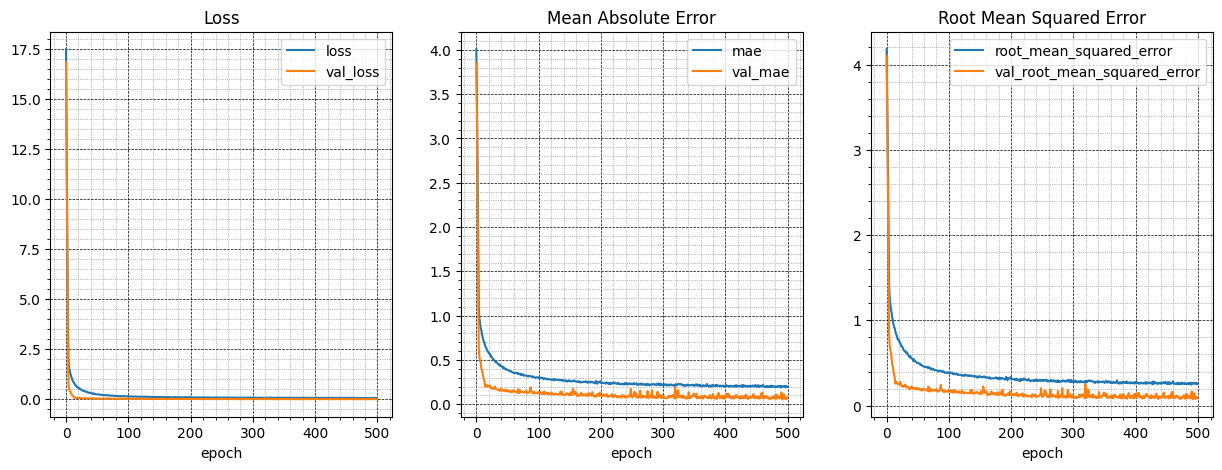

In [11]:
# extract the history dictionary from the keras callback:
history_data = history.history

# drop the r2 scores from the history, getting a dictionary of just loss:
history_data.pop('r2_score', None)
history_data.pop('val_r2_score', None)

# list of metrics, text conversion, & halfway point:
metric_list = list(history_data.keys())
half = int(len(history_data.keys())/2)
metric2text = {'loss' : 'Loss',
               'mae' : 'Mean Absolute Error',
               'root_mean_squared_error': 'Root Mean Squared Error'
               }

# training history analysis:
plt.figure(figsize = (half * 5,5))

# iterate and plot the training values:
for index, metric in enumerate(metric_list[:half]):
    training_metric = metric
    validation_metric = metric_list[index + half]

    plt.subplot(1, half, index + 1)
    plt.plot(history_data[training_metric], label = training_metric)
    plt.plot(history_data[validation_metric], label = validation_metric)
    plt.xlabel('epoch')
    plt.legend(loc = 'upper right')
    plt.minorticks_on()
    plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
    plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
    plt.title(f'{metric2text[training_metric]}')

# **Utilize the Model:**

The model can now be used for predictions since it has been trained. The goal of this is to see the accuracy of the model in prediction, visualize the errors, and test the generalization of the model.

In [12]:
# need to get the test metrics through model evaluation:
test_loss, test_mae, test_rmse = model.evaluate(x_test, y_test)

# need to get the predictions of the model:
pred_start = time.time()
y_pred = model.predict(x_test)
pred_time = time.time() - pred_start

# get the R2 score:
test_r2 = r2_score(y_test, y_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.0074 - mae: 0.0631 - root_mean_squared_error: 0.0856
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Check the memory consumption:

In [13]:
# import memory tracking functionalities:
import psutil

# get process ID:
process = psutil.Process(os.getpid())

# get memory before and after prediction:
mem_before = process.memory_info().rss / 1024 ** 2
y_pred = model.predict(x_test)
mem_after = process.memory_info().rss / 1024 ** 2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step


# **Model Results:**

This section serves to visualize the entirety of the results for testing the model. The metrics that are visualized are the:

* MSE in testing
* MAE in testing
* RMSE in testing
* $R^{2}$ in testing
* Memory consumption of model
* Prediction time of model
* Actual vs. Predicted curve of model
* Histogram of prediction errors

In [14]:
# print model parameters to user:
print(f'test MSE was: {test_loss}\n',
      f'test MAE was: {test_mae}\n', 
      f'test RMSE was: {test_rmse}\n',
      f'test r2 score was: {test_r2}\n',
      f'memory used was: {round((mem_after - mem_before), 32)} MB\n',
      f'prediction time was: {round(pred_time, 3)} seconds')

test MSE was: 0.007760311476886272
 test MAE was: 0.06353077292442322
 test RMSE was: 0.0880926325917244
 test r2 score was: 0.9968778833530701
 memory used was: 0.7734375 MB
 prediction time was: 0.156 seconds


Scatter plot analysis of model:

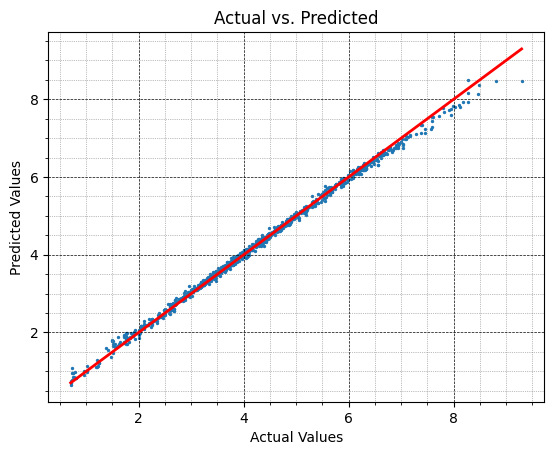

In [15]:
# scatter plot analysis:
plt.figure()
plt.scatter(y_test, y_pred, s = 2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', lw = 2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')

plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

Histogram analysis of model:

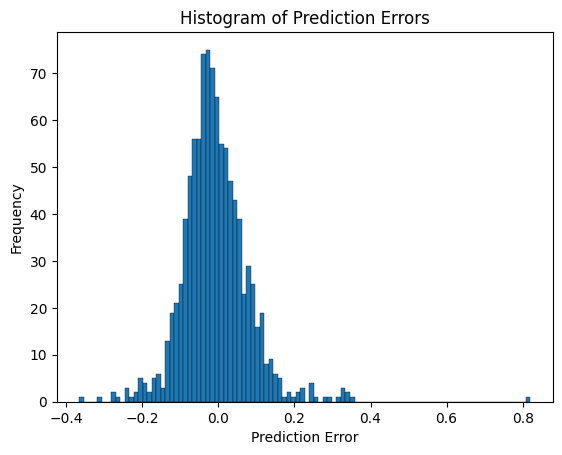

In [16]:
# histogram analysis:
y_test = np.array(y_test).reshape(-1, 1)
error = y_test - y_pred

plt.figure()
plt.hist(error, bins = 100, edgecolor = 'black', linewidth = 0.25)

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

plt.show()

# **Saving the Model:**

The model can then be saved for further use, where it can be deployed at its target destination (i.e. on a robot):


In [17]:
# need to set the model directory and file-type:
model_path = os.path.join(os.getcwd(), 'model.h5')

# save the model:
model.save(model_path)
print(f'model saved to: {model_path}')

model saved to: c:\Users\mtidd2\Desktop\Research\Inference Systems\Python_Design\ANN_Design\ANN_Model_Testing\model.h5
